In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 

import seaborn as sns

2023-10-07 00:07:09.842208: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [44]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}


with open('mushroom_train.pkl', 'rb') as f:
    data = pickle.load(f)
    y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    X = np.array([data[i]["images"].numpy() for i in range(len(data))])

with open('mushroom_test.pkl', 'rb') as f:
    data = pickle.load(f)
    ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

## Specify learning algorithms

In [4]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [5]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=2,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        #thetas[i] = theta
        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)

            grad *= zeta
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = np.clip(prob_const * pz, a_min=0, a_max=1)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 200 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [6]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_new.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [7]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [8]:
# When minimizing train loss
hyperparam_per_algo

{'absloss': {'eta': 140.2762214555256, 'lam': 4.5560291257265163e-05},
 'polyak_absloss': {'eta': 273.78819737581784,
  'kappa': 2.4033587610427127,
  'kappa0': 0.36461817505653205,
  'lam': 4.644814782311994e-05,
  'omega': 0.9999998190737315},
 'polyak_exponent': {'eta': 70.22061050122062,
  'kappa': 3.6974718007476706,
  'kappa0': 0.3660748112757786,
  'lam': 4.591001303161228e-05,
  'polyakexp': 0.6897552648488062},
 'random': {'eta': 90.12506271915134, 'lam': 4.61738603945365e-05}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [12]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **absloss_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6920738537210527, train loss: 0.6931471805599453, ||theta||_1: 81.37633732338986
loss: 0.6223002187118444, train loss: 0.6173697472793307, ||theta||_1: 7112.10513948476
loss: 0.5765801369103299, train loss: 0.17068793691644857, ||theta||_1: 11355.981992768853
loss: 0.5500907571424948, train loss: 0.09102615929832976, ||theta||_1: 13616.811186158786
loss: 0.5317679658825485, train loss: 0.6495941458458221, ||theta||_1: 15308.478175625227
loss: 0.5157215791453681, train loss: 0.5842855646405958, ||theta||_1: 16708.444469228605
loss: 0.506667734682128, train loss: 0.15889601252915572, ||theta||_1: 17587.6625029179
loss: 0.5017395938476253, train loss: 0.4292520391555843, ||theta||_1: 17982.3175747062
loss: 0.4969258493300873, train loss: 0.5146840611730326, ||theta||_1: 18366.896670806607
loss: 0.4913262326080471, train loss: 0.47559159363807924, ||theta||_1: 18493.670083827943
loss: 0.4884652359369111, train loss: 0.376

In [13]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [14]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6557420375642082, train loss: 0.6669013009441365, ||theta||_1: 3208.6272201366833
loss: 0.6245736206763222, train loss: 0.23203306649246086, ||theta||_1: 5970.063066336218
loss: 0.6050758221448648, train loss: 0.19319405973819756, ||theta||_1: 7849.372121009683
loss: 0.5815634642081141, train loss: 0.22258012550211287, ||theta||_1: 9697.453365082081
loss: 0.5619804001230627, train loss: 0.6536252485547576, ||theta||_1: 11247.65790490115
loss: 0.551520802117671, train loss: 0.22431562261936455, ||theta||_1: 12095.096280234347
loss: 0.5405495644881708, train loss: 0.18751611978798577, ||theta||_1: 13232.536203878524
loss: 0.5324085022010662, train loss: 0.32507426517226484, ||theta||_1: 13891.85400827556
loss: 0.5275031020852572, train loss: 0.616939403398694, ||theta||_1: 14297.408597256577
loss: 0.523918538100999, train loss: 0.33977288247322684

In [15]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6920738537210527, train loss: 0.6931471805599453, ||theta||_1: 81.37633732338986
loss: 0.6498420153669376, train loss: 0.6930903548779994, ||theta||_1: 3874.7836040464254
loss: 0.6089242686479078, train loss: 0.6904512263172253, ||theta||_1: 7636.501215222464
loss: 0.5804459061101984, train loss: 0.649174979579814, ||theta||_1: 10323.896220207367
loss: 0.5607696193184813, train loss: 0.15242688146423009, ||theta||_1: 12067.018430364187
loss: 0.5432783035730976, train loss: 0.6704344968442779, ||theta||_1: 13558.241909813372
loss: 0.5329522853122249, train loss: 0.6478595706316624, ||theta||_1: 14471.86855397818
loss: 0.5310310658942176, train loss: 0.14569599999572436, ||theta||_1: 14861.683212336075
loss: 0.5220968490531921, train loss: 0.35464422367559023, ||theta||_1: 15554.362980678357
loss: 0.5170698479069079, train loss: 0.42165156139386323, ||theta||_1: 15810.0327428631
loss: 0.5159331464908565, train loss: 0.06

In [16]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6923779903024173, train loss: 0.6931471805599453, ||theta||_1: 52.28289890493365
loss: 0.6397710921021833, train loss: 0.619241341845244, ||theta||_1: 4949.446085564329
loss: 0.6064474528943852, train loss: 0.23995897610412784, ||theta||_1: 7836.025533990904
loss: 0.5773871610234915, train loss: 0.6239238505349729, ||theta||_1: 10392.215913755623
loss: 0.5553596522481072, train loss: 0.24077743329512086, ||theta||_1: 12298.158154054829
loss: 0.5399664625785127, train loss: 0.594466753693253, ||theta||_1: 13341.566091440474
loss: 0.5295426416113515, train loss: 0.6473909335245497, ||theta||_1: 14361.651120101258
loss: 0.5235249102197848, train loss: 0.6023722751510042, ||theta||_1: 15108.863593549157
loss: 0.5145655661977777, train loss: 0.30033645384220964, ||theta||_1: 15679.27016857355
loss: 0.5076828024417376, train loss: 0.39595935952668865, ||theta||_1: 16277.493778191176
loss: 0.5029996723807129, train loss: 0.1

In [17]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

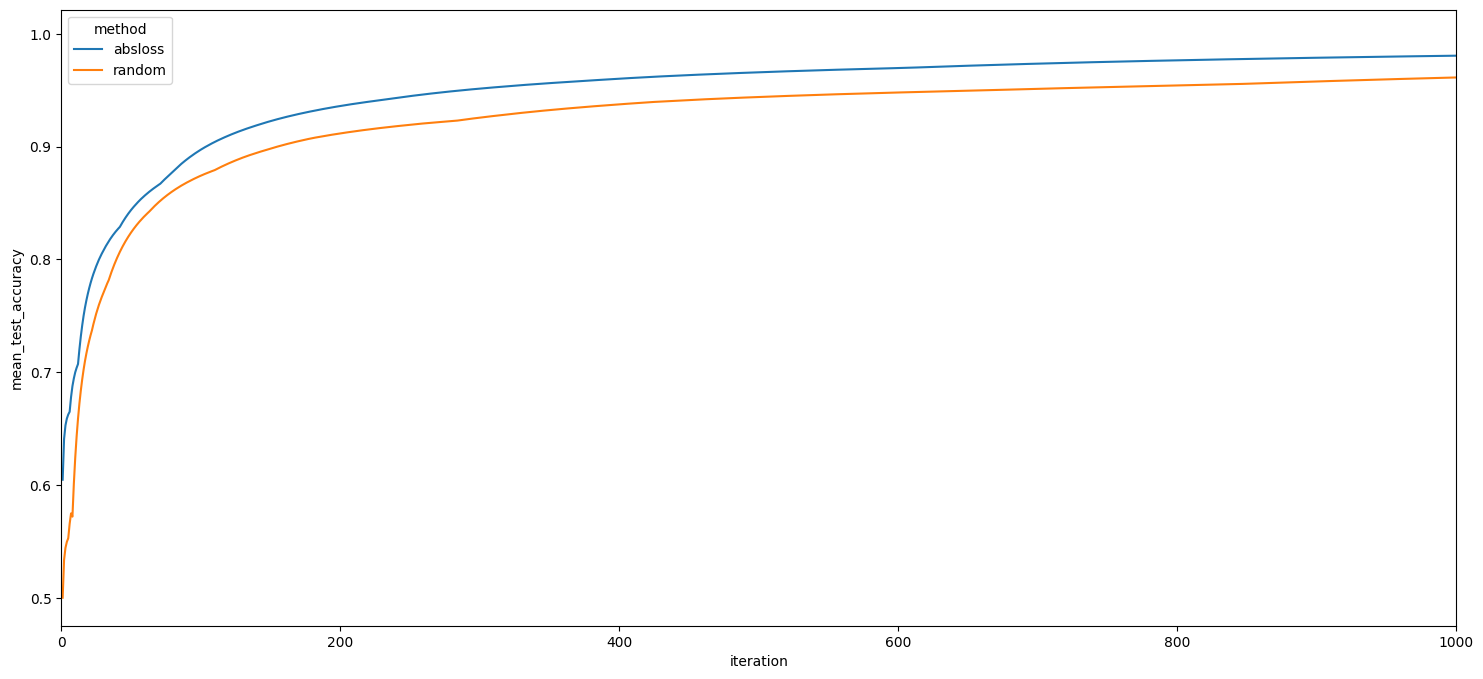

In [18]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

(0.0, 1000.0)

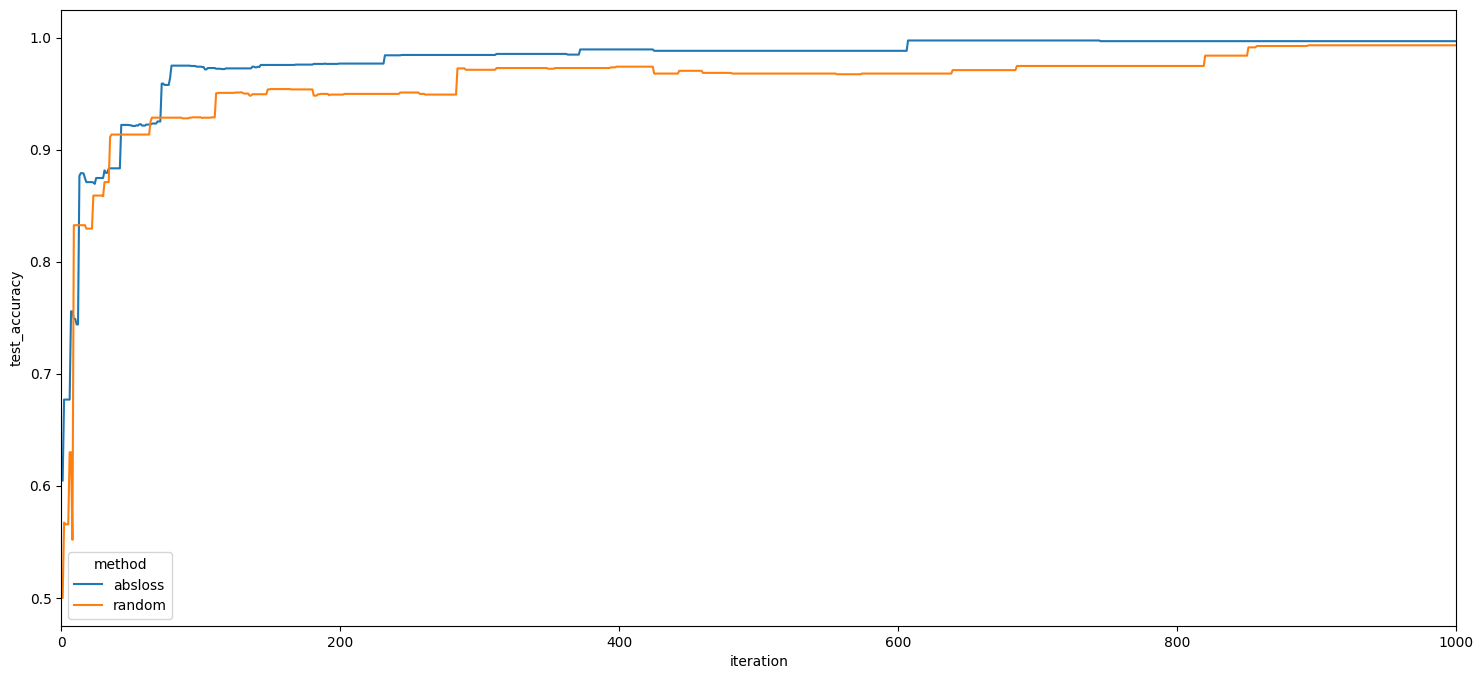

In [19]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

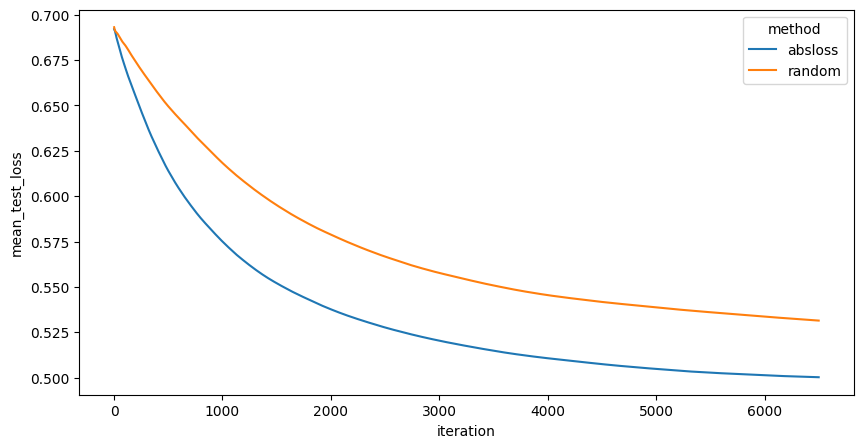

In [20]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

Text(0, 0.5, 'average cross entropy loss')

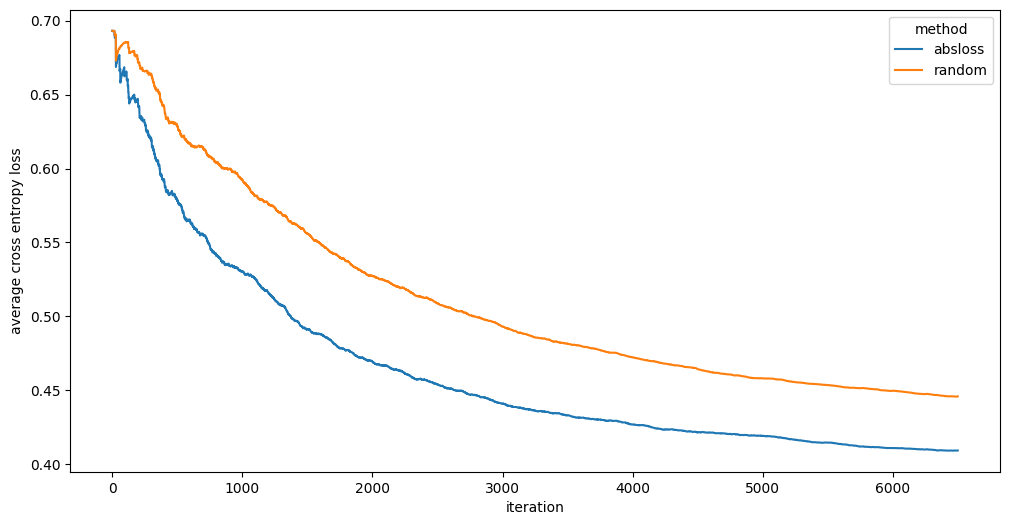

In [21]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

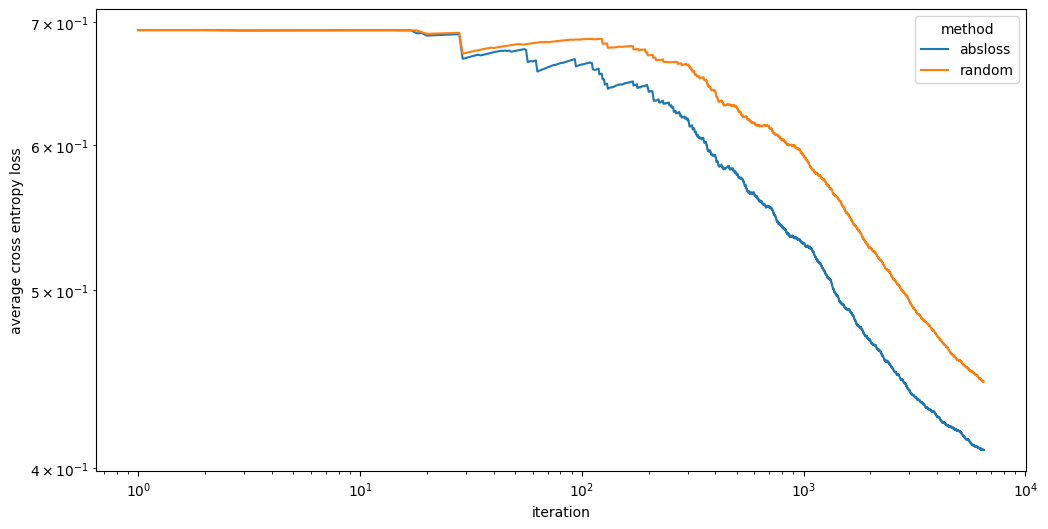

In [43]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [22]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6658404289650649, train loss: 0.6495309609463283, ||theta||_1: 2393.982946107946
loss: 0.6377230128823161, train loss: 0.6930079194987371, ||theta||_1: 4786.792266671224
loss: 0.6179436422752703, train loss: 0.25044293218066044, ||theta||_1: 6696.442681298228
loss: 0.5999850434165993, train loss: 0.27534819443887615, ||theta||_1: 8152.8521208963975
loss: 0.5799170827204168, train loss: 0.6814858133368424, ||theta||_1: 9711.391629973994
loss: 0.5677087859218629, train loss: 0.6543879260474024, ||theta||_1: 10776.342350724677
loss: 0.55738762844055, train loss: 0.6181391049543081, ||theta||_1: 11703.959689787955
loss: 0.5477930295730609, train loss: 0.6339959342873732, ||theta||_1: 12620.043271958988
loss: 0.539187576666692, train loss: 0.4422281183555039, ||theta||_1: 13161.940533016348
loss: 0.5371523279592773, train loss: 0.46329385741

In [23]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.001, 0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[6.873952178693168,
 4.582634785795445,
 2.2913173928977226,
 1.3795105296976125,
 0.6897552648488062]

In [24]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [25]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [26]:
empirical_pzs

[0.0010000000000000007,
 0.010000000000000005,
 0.10000000000000002,
 0.24999999999999997,
 0.5]

In [27]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [28]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [29]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.min()

method           polyak_exp  probs
polyak_exponent  0.7         0.500    0.062627
                 1.4         0.250    0.003227
                 2.3         0.100    0.000008
                 4.6         0.010   -0.000000
                 6.9         0.001   -0.000000
random           0.7         0.500    0.014130
                 1.4         0.250    0.011446
                 2.3         0.100    0.013893
                 4.6         0.010    0.038259
                 6.9         0.001    0.172433
Name: train_loss, dtype: float64

In [30]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs
polyak_exponent  0.7         0.500    0.468586
                 1.4         0.250    0.420376
                 2.3         0.100    0.440874
                 4.6         0.010    0.566119
                 6.9         0.001    0.676504
random           0.7         0.500    0.429357
                 1.4         0.250    0.456064
                 2.3         0.100    0.524873
                 4.6         0.010    0.669309
                 6.9         0.001    0.690726
Name: mean_train_loss, dtype: float64

Polyak exp value 6.9 has rows (12998, 16)
Polyak exp value 4.6 has rows (12998, 16)
Polyak exp value 2.3 has rows (12998, 16)
Polyak exp value 1.4 has rows (12998, 16)
Polyak exp value 0.7 has rows (12998, 16)


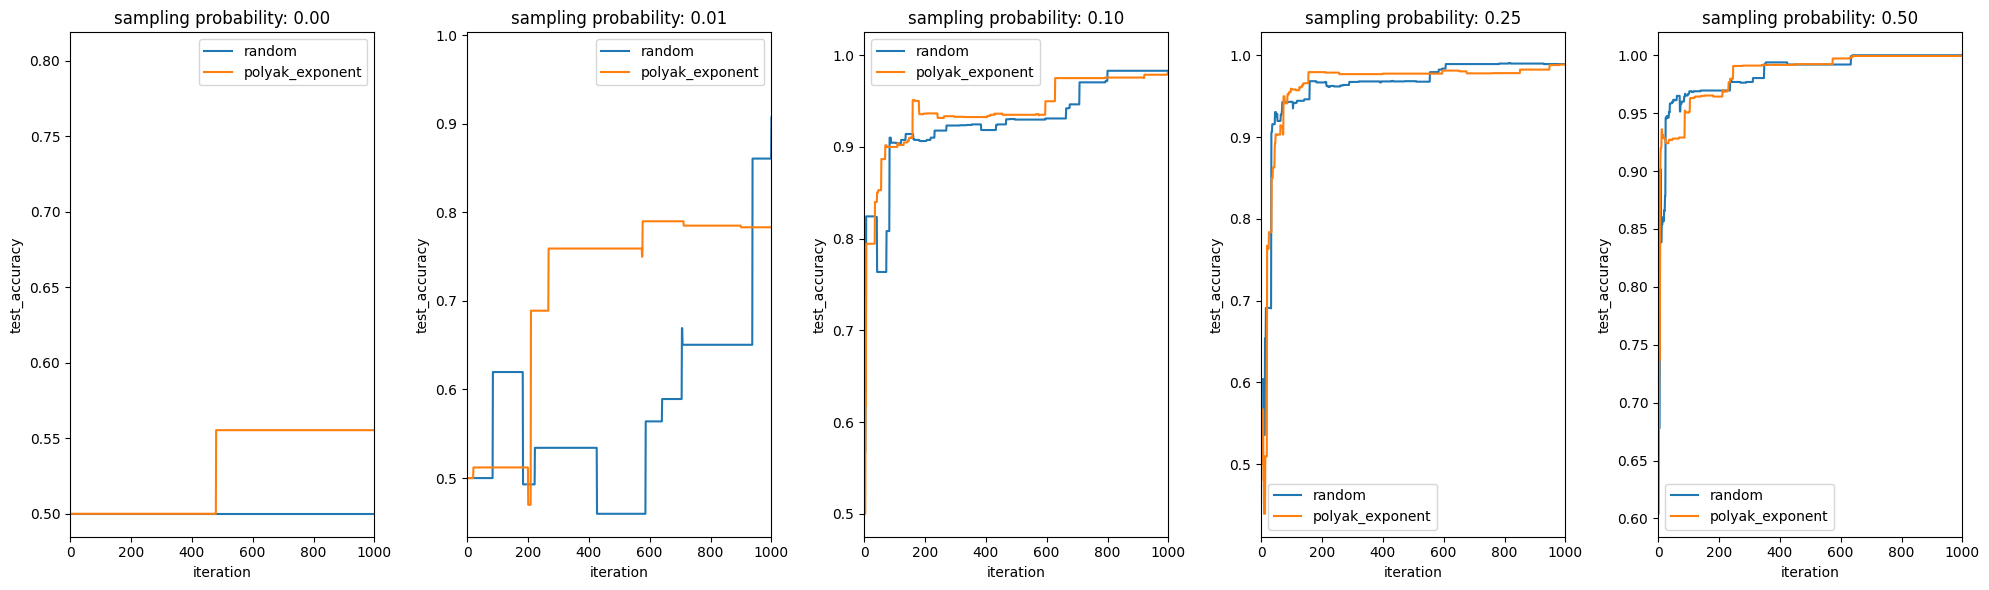

In [31]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 6.9 has rows (12998, 16)
Polyak exp value 4.6 has rows (12998, 16)
Polyak exp value 2.3 has rows (12998, 16)
Polyak exp value 1.4 has rows (12998, 16)
Polyak exp value 0.7 has rows (12998, 16)


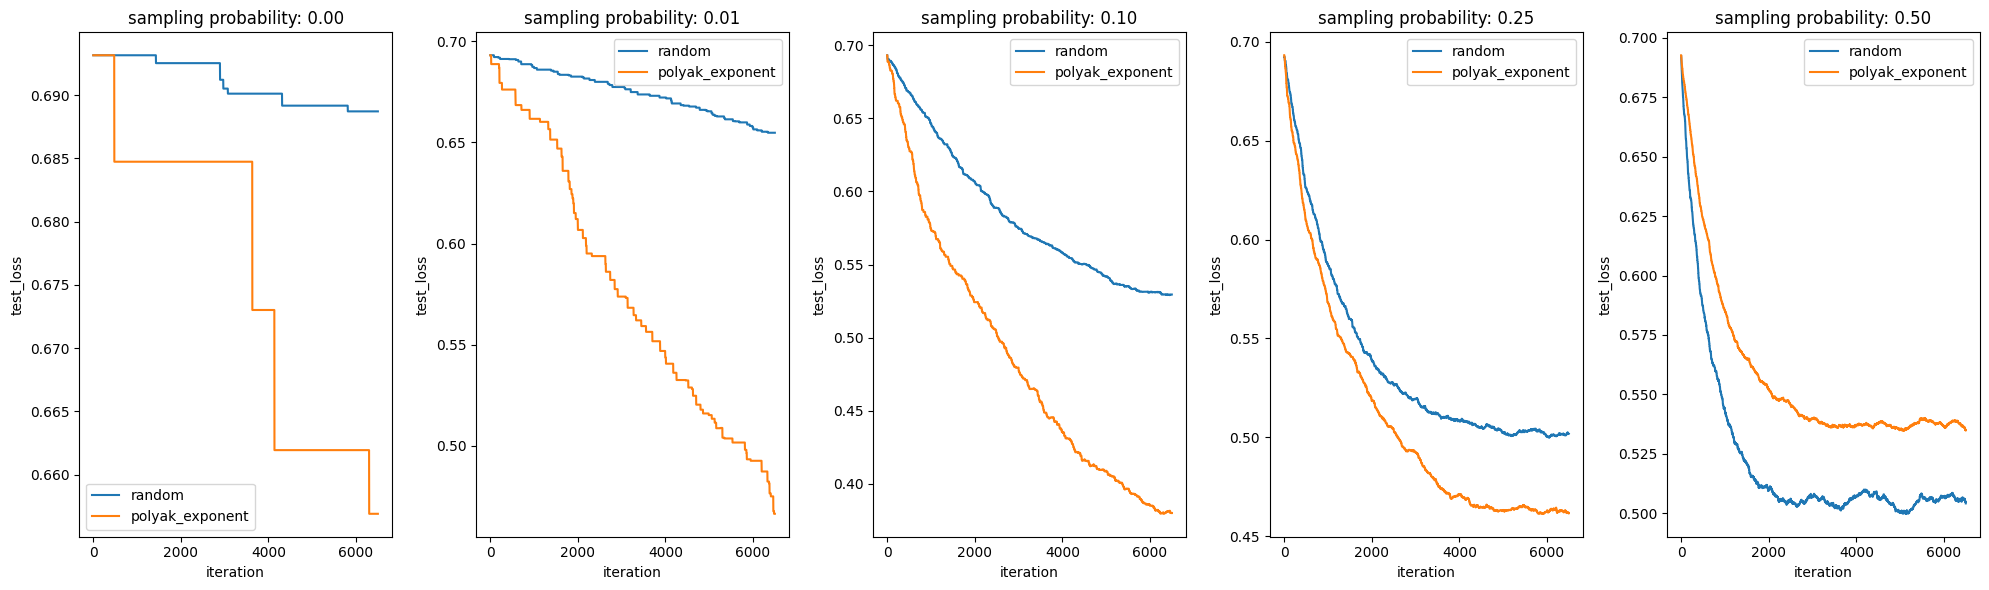

In [45]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

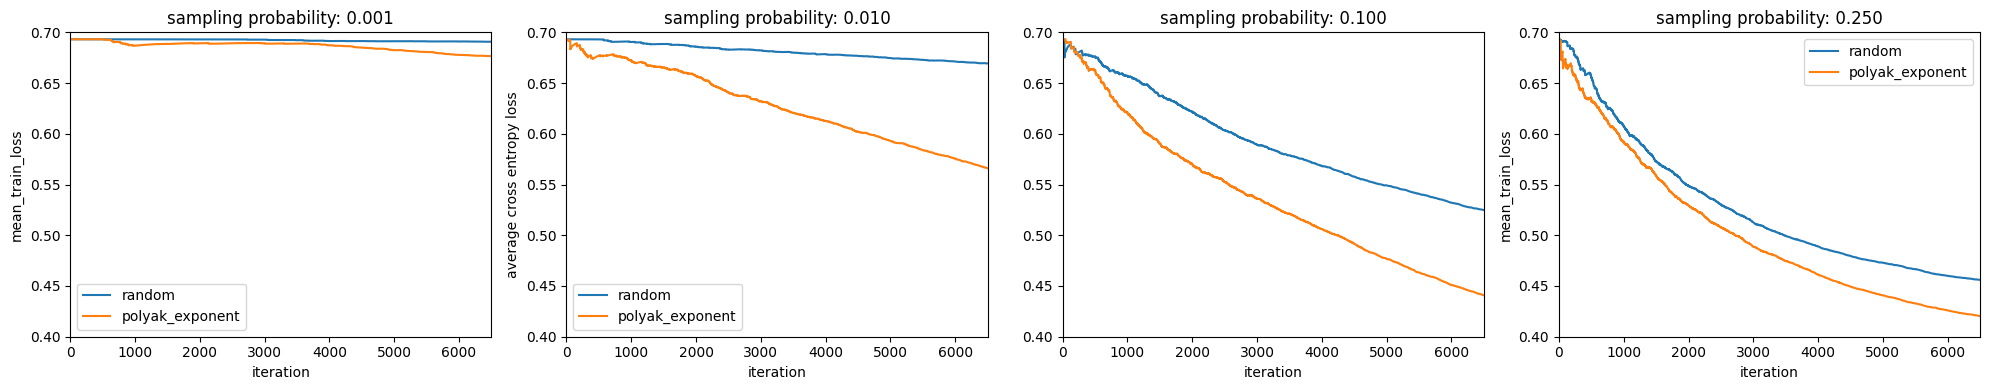

In [48]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    if pz > 0.26:
        continue
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.40, 0.7))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[1].set_ylabel("average cross entropy loss")
axs[2].set_ylabel("")

axs[2].get_legend().remove()

f.tight_layout()

0.0010000000000000007
Polyak exp value 6.9 has rows (12998, 16)
0.010000000000000005
Polyak exp value 4.6 has rows (12998, 16)
0.10000000000000002
Polyak exp value 2.3 has rows (12998, 16)
0.24999999999999997
Polyak exp value 1.4 has rows (12998, 16)
0.5
Polyak exp value 0.7 has rows (12998, 16)


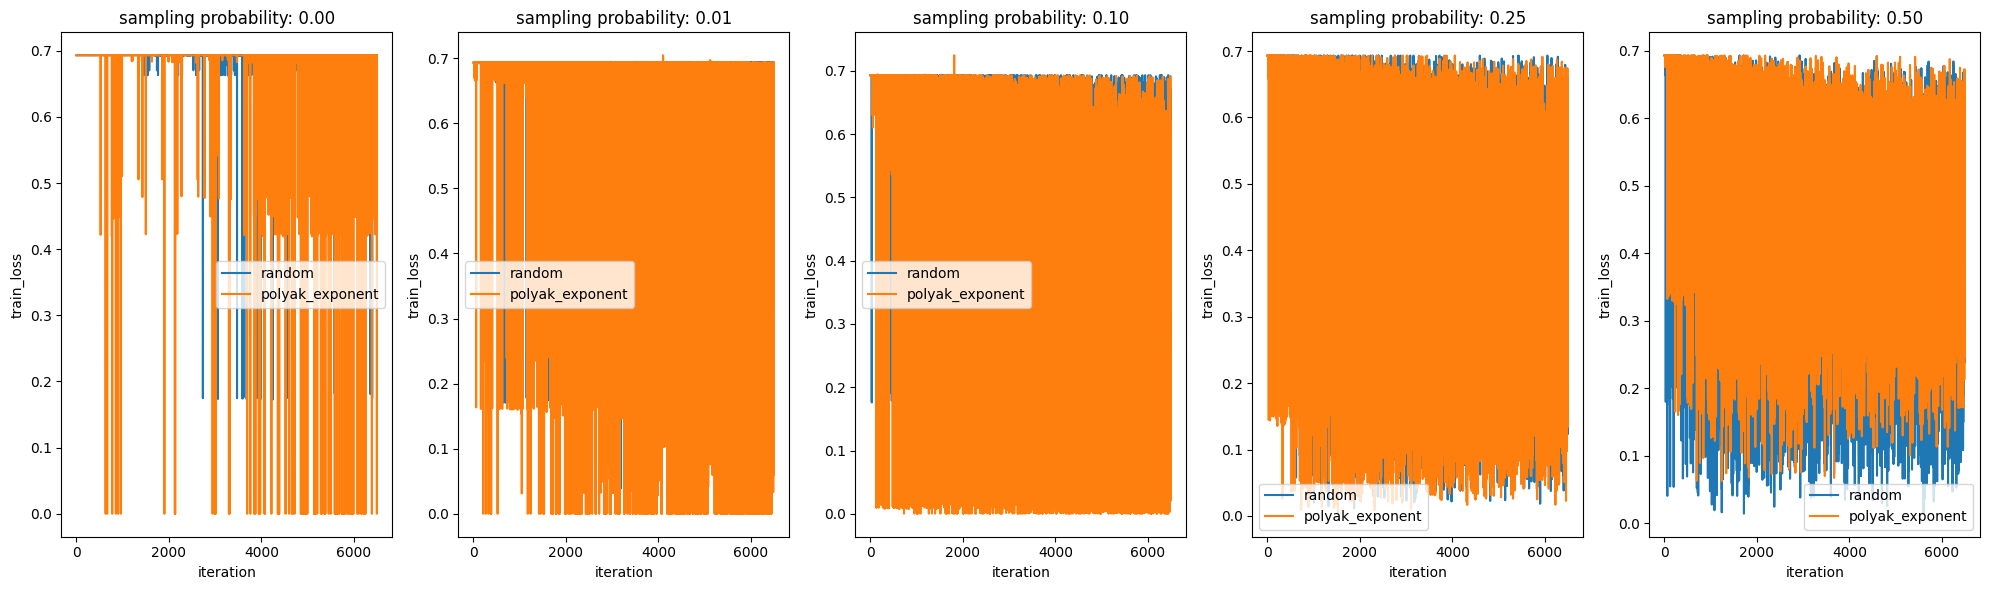

In [34]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.0010000000000000007
Polyak exp value 6.9 has rows (12998, 16)
0.010000000000000005
Polyak exp value 4.6 has rows (12998, 16)
0.10000000000000002
Polyak exp value 2.3 has rows (12998, 16)
0.24999999999999997
Polyak exp value 1.4 has rows (12998, 16)
0.5
Polyak exp value 0.7 has rows (12998, 16)


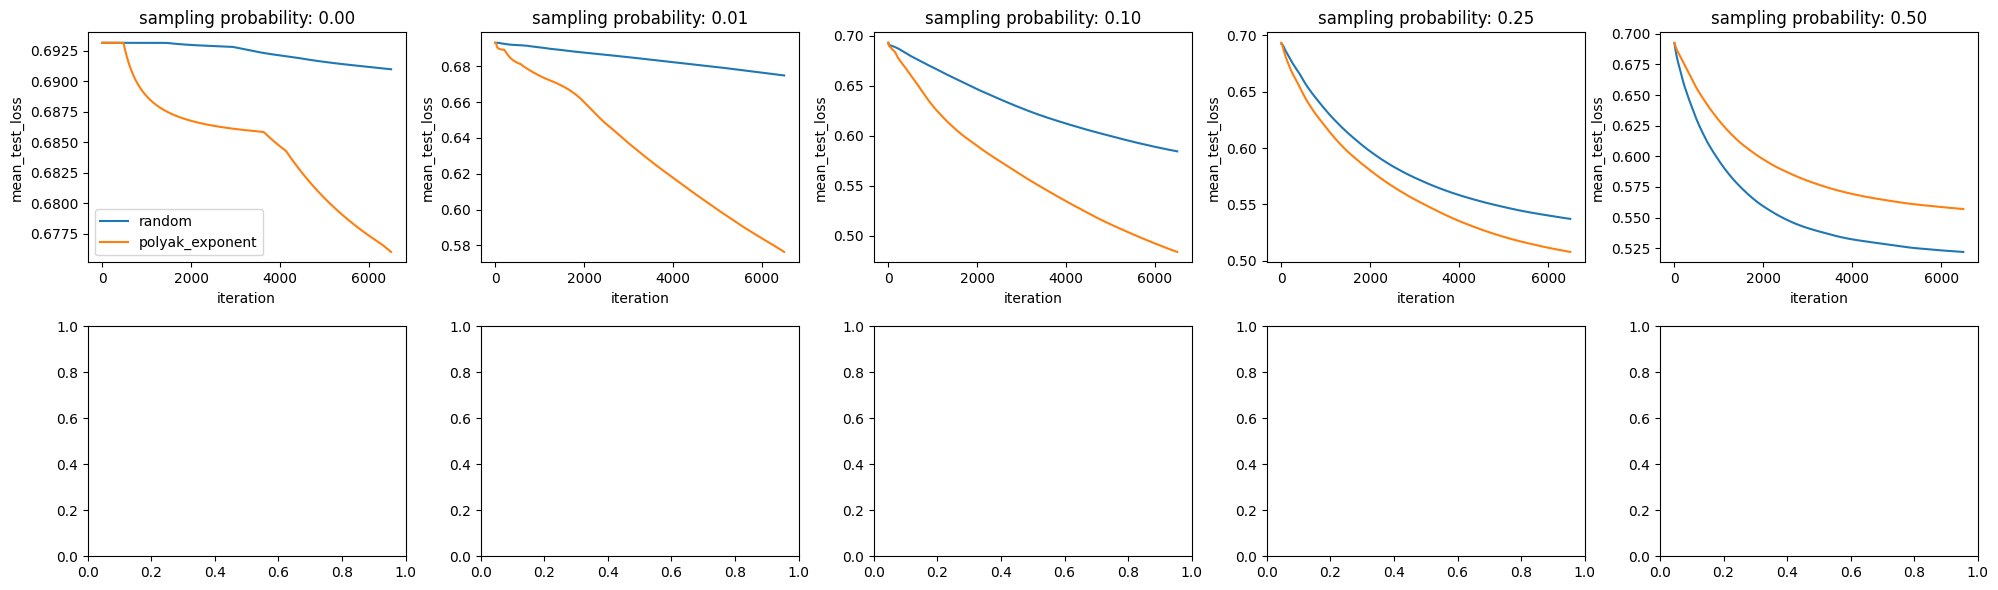

In [35]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [36]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, **(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
)

Training with algorithm polyak_absloss: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6067099771400317, train loss: 0.5972319756997548, ||theta||_1: 8517.34846706073
loss: 0.5716766333526998, train loss: 0.1867486659725528, ||theta||_1: 12056.105311076366
loss: 0.5504618279203466, train loss: 0.6371077385055188, ||theta||_1: 14725.378244541369
loss: 0.5348093807154278, train loss: 0.16143418222919512, ||theta||_1: 16190.421746220125
loss: 0.5161582091966533, train loss: 0.6140007979724295, ||theta||_1: 16928.100225360282
loss: 0.5089929815280008, train loss: 0.6577043282564643, ||theta||_1: 17463.564011238694
loss: 0.5106251368504899, train loss: 0.035815587510968576, ||theta||_1: 17848.782981574346
loss: 0.5117252169912289, train loss: 0.3018359718235344, ||theta||_1: 18079.76488110458
loss: 0.5045654456313722, train loss: 0.5597892609892441, ||theta||_1: 18139.18612456623
loss: 0.5047448126422284, train loss: 0.00606893

In [49]:
np.mean(results_absloss["probs"])

0.3211203432482956

In [50]:
np.mean(results_polyak_absloss["probs"])

0.3463265137506431

In [37]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

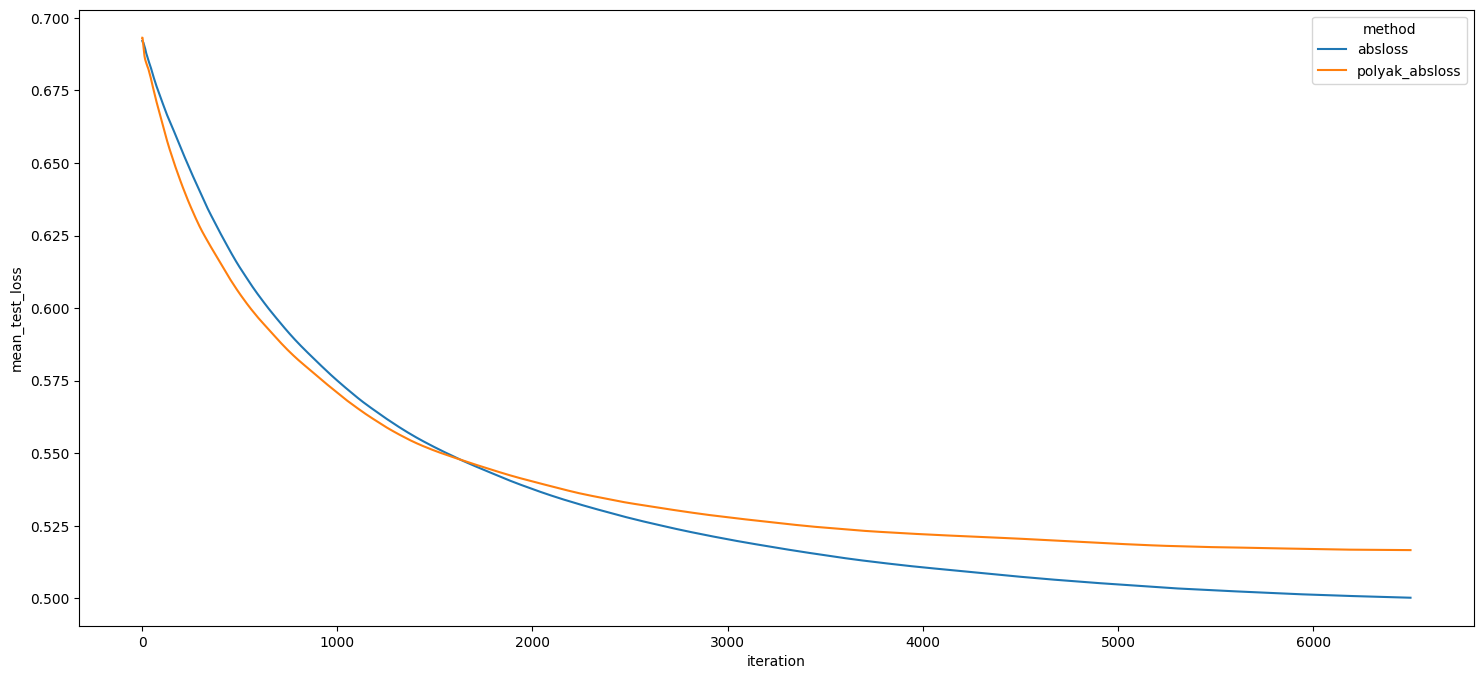

In [38]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

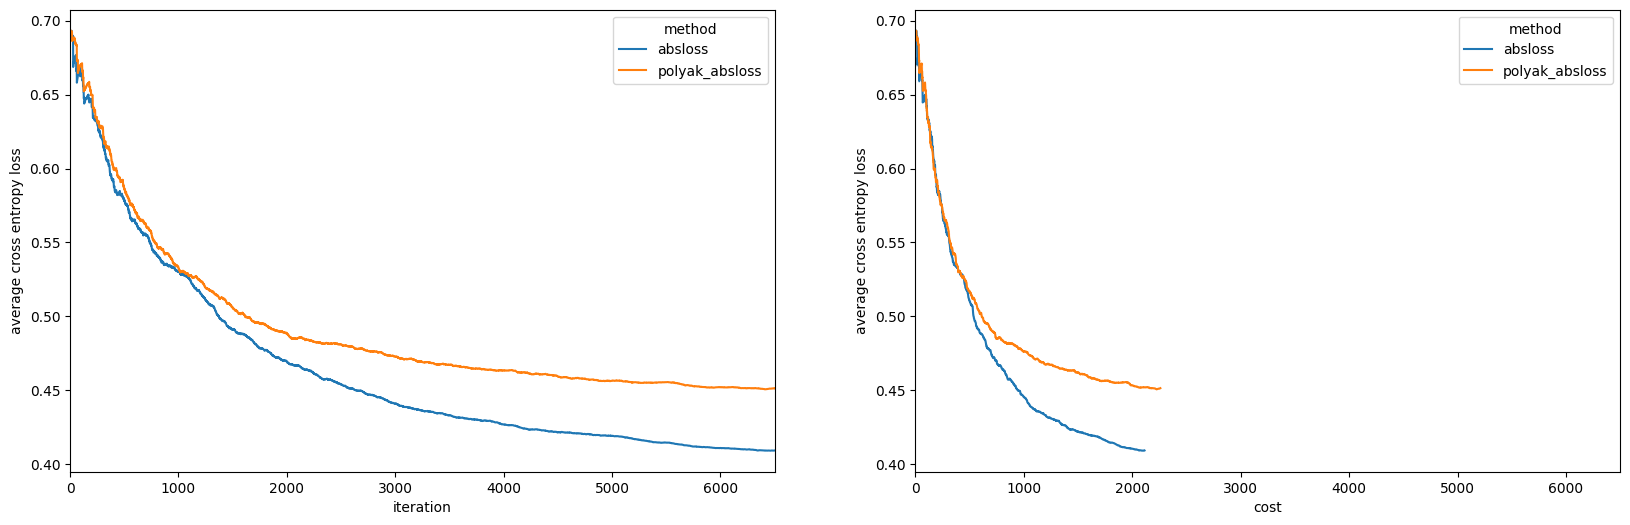

In [39]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

<Axes: xlabel='iteration', ylabel='mean_test_accuracy'>

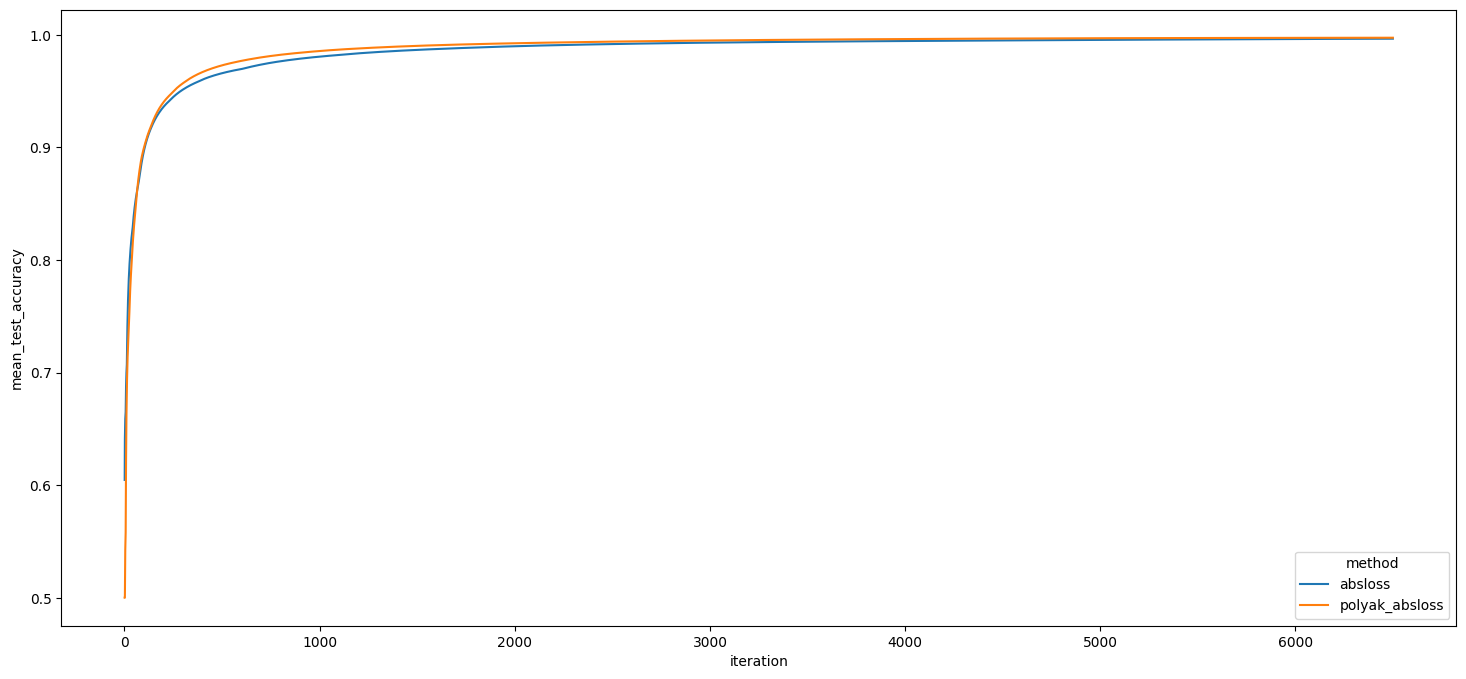

In [40]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

In [41]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

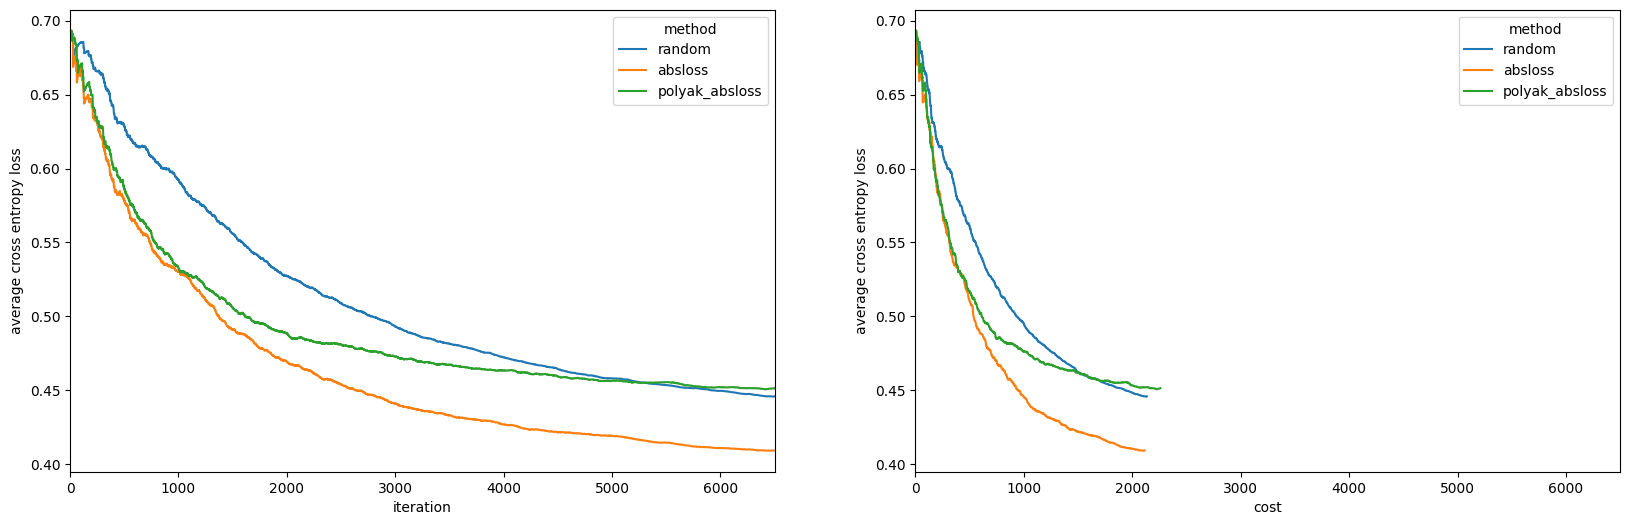

In [42]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))